# Notebook # 1

This is the second notebook in the supporting material for the medium article [Getting Started with Azure Machine Learning and the Python SDK](https://medium.com/p/967c99418df1/)

For the sake of clarity all packages and modules are imported in the cells in which they are used.

# Load all assets.
Load in the assets we created in the previous notebook

In [1]:
from azureml.core import Workspace, Dataset, Environment

# Load the stored workspace
ws = Workspace.from_config()

# Get the registered dataset from azure
dataset = Dataset.get_by_name(ws, name='waste_images')

## Try with our saved image
env = Environment.get(workspace=ws, name="waste-env-gpu")

# get our compute target
compute_target = ws.compute_targets["gpu-cluster-NC6"]

## Define experiment name
An experiment is a container for one or more model runs.  You can group iterations of a model into an experiment for easy access on azureml Studio.  Every run must be in an experiment.

In [2]:
from azureml.core import Experiment

# define the expiriment
exp = Experiment(workspace=ws, name='recycling')

## Create train script
The train script is what will be executed on the azureml compute instance.  The directory specified will be uploaded and other assets or modules can be included in that directory.

In [5]:
import os

# create a directory for the training script
os.makedirs('train_script', exist_ok=True)

In [26]:
%%writefile train_script/train.py

import argparse
import os
import pickle

import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# output will be logged, separate output from previous log entries.
print('-'*100)

def parse_args():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data-path', type=str, 
                        dest='data_path', 
                        default='data', 
                        help='data folder mounting point')

    return parser.parse_args()


if __name__ == '__main__':

    # parse the parameters passed to the this script
    args = parse_args()

    # set data paths
    train_folder = os.path.join(args.data_path, 'train')
    val_folder = os.path.join(args.data_path, 'validation')


    # Create ImageGenerators
    print('Creating train ImageDataGenerator')
    train_generator = ImageDataGenerator(rescale=1/255)\
                            .flow_from_directory(train_folder, 
                                                 batch_size = 32)
    val_generator = ImageDataGenerator(rescale=1/255)\
                            .flow_from_directory(val_folder, 
                                                 batch_size = 32)

    # Build the model
    model = K.models.Sequential()
    model.add(K.layers.Conv2D(32, (2,2), activation='relu'))
    model.add(K.layers.MaxPooling2D(2,2))
    model.add(K.layers.Flatten())
    model.add(K.layers.Dense(6, activation='softmax'))

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['acc'])

    # fit model and store history
    history = model.fit(train_generator, 
                        validation_data=val_generator,
                        epochs=10)

    print('Saving model history...')
    with open(f'outputs/model.history', 'wb') as f:
        pickle.dump(history.history, f)

    print('Saving model history...')
    model.save(f'outputs/model.model')

    print('Done!')
    print('-'*100)

Overwriting train_script/train.py


## Run the Model

In [24]:
from azureml.core import ScriptRunConfig

# setup the run details
src = ScriptRunConfig(source_directory='train_script',
                      script='train.py',
                      arguments=['--data-path', dataset.as_mount()],
                      compute_target=compute_target,
                      environment=env)

# Submit the model to azure!
run = exp.submit(config=src)

# Download model
The model runs asynchronously.  You have to wait for the run to complete to download the files.

In [27]:
# Check that the run is complete
run.get_status()

'Completed'

In [32]:
# make sure the path exists
os.makedirs('model', exist_ok=True)

# Download the files.
run.download_files(output_directory='cloud_files')

In [34]:
import tensorflow.keras as K

# load the model
model = K.models.load_model(f'cloud_files/outputs/model.model')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, None, None, 32)    416       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, None, None, 32)    0         
_________________________________________________________________
flatten (Flatten)            (None, None)              0         
_________________________________________________________________
dense (Dense)                (None, 6)                 3096774   
Total params: 3,097,190
Trainable params: 3,097,190
Non-trainable params: 0
_________________________________________________________________


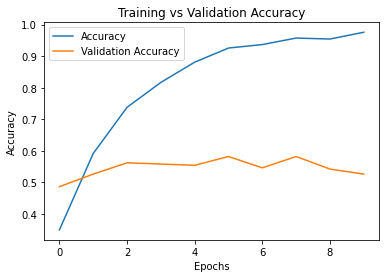

In [45]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

# load model history
with open(f'cloud_files/outputs/model.history', 'rb') as fp:
    history = pickle.load(fp)
    
plt.plot(history['acc'], label='Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()